In [1]:
API_KEY = ''
API_SECRET = ''

from binance.client import Client
client = Client(API_KEY, API_SECRET)

In [61]:
MINUTES_NUMBER = 5000
COMMISION_RATE = 0.0001

In [2]:
import pandas as pd

In [53]:
historical_klines

,time,price
0,2021-09-10 10:28:59.999,46136.08000000
1,2021-09-10 10:29:59.999,46157.27000000
2,2021-09-10 10:30:59.999,46175.35000000
3,2021-09-10 10:31:59.999,46198.58000000
4,2021-09-10 10:32:59.999,46205.42000000
...,...,...
4995,2021-09-13 21:43:59.999,44979.58000000
4996,2021-09-13 21:44:59.999,45013.82000000
4997,2021-09-13 21:45:59.999,45030.50000000
4998,2021-09-13 21:46:59.999,45052.30000000


In [52]:
historical_klines = pd.DataFrame()
for kline in client.get_historical_klines_generator("BTCUSDT", Client.KLINE_INTERVAL_1MINUTE, f"{MINUTES_NUMBER} minutes ago UTC"):
    close_price = kline[4]
    close_time = kline[6]
    historical_klines = historical_klines.append({'time': pd.to_datetime(close_time, unit='ms'), 'price': close_price}, ignore_index=True)

In [67]:
def backtest(long_window, short_window):
    df = historical_klines.copy()
    df['mean_long'] = df['price'].rolling(long_window).mean()
    df['mean_short'] = df['price'].rolling(short_window).mean()
    df['strategy'] = get_strategies(df)
#     print(df)
    df = df.iloc[(long_window-1):,]
    df['strategy'] = pd.to_numeric(df['strategy'])
    df['price'] = pd.to_numeric(df['price'])
    df.loc[:, 'buy_price'] = df.loc[:, 'price'] * df.loc[:, 'strategy']
    df = df[df['strategy'] != 0]
    df['next_price'] = df['buy_price'].shift(-1)
#     print(df)
    df = df[~df['next_price'].isna()]
    df['profit'] = np.where(
        df['strategy'] == -1,
        (df['price'] - df['next_price']) + df['buy_price'] * COMMISION_RATE - df['next_price'] * COMMISION_RATE,
        -(df['next_price'] + df['price']) - df['buy_price'] * COMMISION_RATE + df['next_price'] * COMMISION_RATE)

    return df['profit'].sum()

In [44]:
def get_strategies(df):
    sign = None
    strategies = []

    for row in df.iterrows():
        mean_short, mean_long = row[1]['mean_short'], row[1]['mean_long']

        if pd.isna(mean_long):
            strategies.append(pd.NA)
            continue

        local_sign = (mean_short - mean_long) >= 0
        strategy = 0

        if sign == None:
            sign = local_sign

        if local_sign != sign: # знак поменялся
            if local_sign: # поменялся с - на +
                strategy = 1
            else: # поменялся с + на -
                strategy = -1

        sign = local_sign
        strategies.append(strategy)
        
    return strategies

In [49]:
%%timeit
backtest(25, 7)

26.8 ms ± 905 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [40]:
historical_klines

,time,price
0,2021-09-13 17:19:59.999,44359.50000000
1,2021-09-13 17:20:59.999,44393.00000000
2,2021-09-13 17:21:59.999,44414.86000000
3,2021-09-13 17:22:59.999,44452.31000000
4,2021-09-13 17:23:59.999,44463.06000000
...,...,...
255,2021-09-13 21:34:59.999,45049.94000000
256,2021-09-13 21:35:59.999,45063.01000000
257,2021-09-13 21:36:59.999,45024.45000000
258,2021-09-13 21:37:59.999,44975.74000000


In [23]:
df

NameError: name 'df' is not defined

In [33]:
historical_klines

,time,price
0,2021-09-13 16:39:59.999,44253.38000000
1,2021-09-13 16:40:59.999,44232.43000000
2,2021-09-13 16:41:59.999,44302.59000000
3,2021-09-13 16:42:59.999,44257.46000000
4,2021-09-13 16:43:59.999,44260.00000000
...,...,...
515,2021-09-13 21:29:59.999,45039.23000000
516,2021-09-13 21:30:59.999,45051.58000000
517,2021-09-13 21:31:59.999,45050.02000000
518,2021-09-13 21:32:59.999,45055.71000000


In [71]:
results = {}

for short_window in tqdm(range(5, 195, 5)):
    for long_window in tqdm(range(short_window + 5, 200, 5)):
        results[backtest(long_window, short_window)] = (long_window, short_window)

/tmp/ipykernel_70/820550862.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for short_window in tqdm(range(5, 195, 5)):


  0%|          | 0/38 [00:00<?, ?it/s]

/tmp/ipykernel_70/820550862.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for long_window in tqdm(range(short_window + 5, 200, 5)):


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [58]:
from tqdm import tqdm_notebook as tqdm

In [72]:
max(results)

3077.655258999967

In [73]:
results[3077.655258999967]

(20, 15)

In [70]:
backtest(20, 15)

3077.655258999967

In [74]:
results

{-2967.435061999959: (10, 5),
 -3387.322906999897: (15, 5),
 -5048.332756999935: (20, 5),
 -2201.3564160000005: (25, 5),
 -1517.1366320000436: (30, 5),
 -3571.321914999951: (35, 5),
 -2957.0950119999907: (40, 5),
 -1200.5263740000205: (45, 5),
 -1185.819522000047: (50, 5),
 -1028.4484850000736: (55, 5),
 -180.31959100004605: (60, 5),
 76.40293000004539: (65, 5),
 -854.9798129999383: (70, 5),
 -774.8275979999823: (75, 5),
 247.93348700007016: (80, 5),
 278.1050530000342: (85, 5),
 36.78859700004941: (90, 5),
 238.72117900004895: (95, 5),
 16.635576999976763: (100, 5),
 -0.5483669999733252: (105, 5),
 -552.9211619999146: (110, 5),
 28.520666000085612: (115, 5),
 -1119.4954899999784: (120, 5),
 -1913.2591379999549: (125, 5),
 -2443.681323999892: (130, 5),
 -2386.5453550000034: (135, 5),
 -1982.9223350000032: (140, 5),
 -1748.5111649999815: (145, 5),
 -2405.722995999971: (150, 5),
 -2331.7797579999465: (155, 5),
 -2314.252529999988: (160, 5),
 -2506.995311000021: (165, 5),
 -2445.900658999

In [77]:
historical_klines['price'] = pd.to_numeric(historical_klines['price'])

<AxesSubplot:>

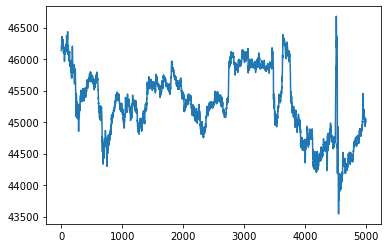

In [78]:
historical_klines['price'].plot()